In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

rcParams['font.family'] = ['Trebuchet MS']
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [2]:
abgrid_long = pd.read_excel("./analysis/abgrid_long.xlsx")
abgrid_wide = pd.read_excel("./analysis/abgrid_wide.xlsx")
safa_anx =  pd.read_excel("./analysis/safa_anx.xlsx")
mmpia = pd.read_excel("./analysis/mmpia.xlsx")
mmpia = mmpia.sort_values(by="id").set_index("id")

abgrid_long.head()

,id,anno,contesto,lettera,ic_raw_a,pr_raw_a,bt_raw_a,cl_raw_a,hu_raw_a,nd_a,ic_pctile_a,pr_pctile_a,bt_pctile_a,cl_pctile_a,hu_pctile_a,ic_raw_b,pr_raw_b,bt_raw_b,cl_raw_b,hu_raw_b,nd_b,ic_pctile_b,pr_pctile_b,bt_pctile_b,cl_pctile_b,hu_pctile_b,rp,rr,gp,gr,mp,mr,bl,or,im,ac_raw,ac,ic_raw,ic,st,status
0,abbamondi mario,i,stu,A,0.000000,0.004934,0.000000,0.000000,0.017801,1,0.118421,0.118421,0.157895,0.118421,0.184211,0.054054,0.017352,0.008258,0.054054,0.057605,0,0.750000,0.578947,0.763158,0.578947,0.828947,0,2,3,3,0,0,-2,0,2,-2,92,0,92,underrated,NaN
1,albanese michelle,i,stu,B,0.027027,0.042179,0.141479,0.335949,0.019750,0,0.381579,0.815789,0.973684,0.763158,0.236842,0.027027,0.029406,0.005255,0.204247,0.081605,0,0.578947,0.684211,0.710526,0.763158,1.000000,1,1,3,3,0,1,0,0,2,0,95,1,94,underrated,NaN
2,bagatin giulio,i,stu,C,0.054054,0.011243,0.014802,0.202878,0.025469,0,0.618421,0.473684,0.552632,0.473684,0.500000,0.000000,0.011076,0.000000,0.000000,0.018157,1,0.236842,0.236842,0.328947,0.236842,0.500000,2,0,3,3,0,0,2,0,2,2,99,2,97,underrated,NaN
3,bonfanti francesca,i,stu,D,0.378378,0.051730,0.091629,0.395484,0.042549,0,1.000000,0.868421,0.894737,0.894737,0.973684,0.027027,0.015355,0.000751,0.040541,0.001682,0,0.578947,0.539474,0.657895,0.539474,0.394737,14,1,3,2,1,0,13,1,15,14,122,15,129,popular,NaN
4,ciliento giacomo pio,i,stu,E,0.081081,0.038719,0.022472,0.343332,0.039374,0,0.763158,0.789474,0.578947,0.789474,0.894737,0.000000,0.011076,0.000000,0.000000,0.000000,3,0.236842,0.236842,0.328947,0.236842,0.184211,3,0,3,0,0,0,3,3,3,6,107,3,99,-,NaN


## ABGRID

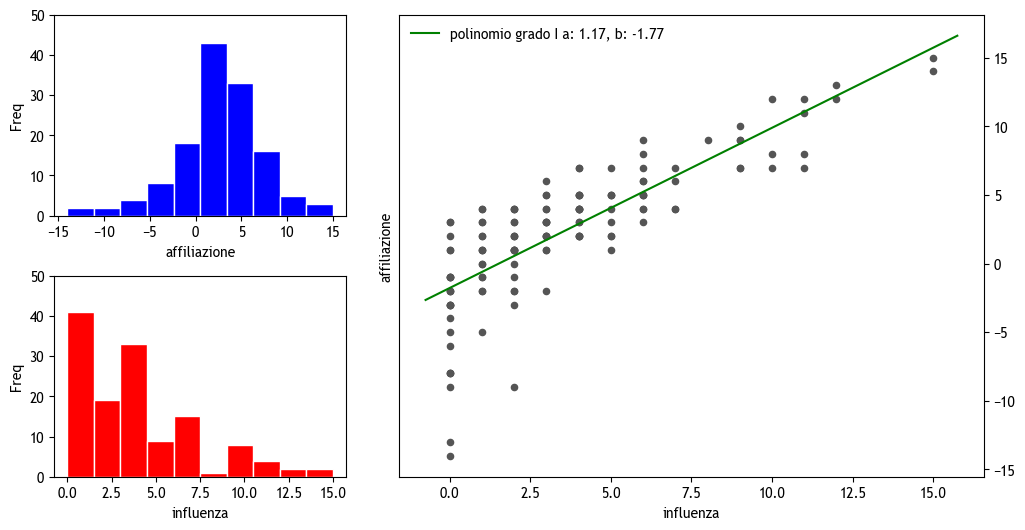

In [3]:
fig = plt.figure(figsize=(12,6))

AFF = "ac_raw"
INF = "ic_raw"

gs = GridSpec(nrows=2, ncols=2, width_ratios=[1,2], hspace=.3, wspace=.12)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[:,1])

abgrid_long[AFF].plot.hist(ax=ax1, color="#00F", ec='#FFF')
ax1.set_xlabel("affiliazione")

abgrid_long[INF].plot.hist(ax=ax2, color="#F00", ec='#FFF')
ax2.set_xlabel("influenza")

for ax in (ax1, ax2):
    ax.set_ylabel("Freq")
    ax.set_ylim(0,50)


abgrid_long.plot.scatter(x=INF, y=AFF, color="#555555",  ax=ax3)

coefficients = np.polyfit(abgrid_long[INF], abgrid_long[AFF], 1)
polynomial = np.poly1d(coefficients)
x_line = np.linspace(ax3.get_xlim()[0], ax3.get_xlim()[1], abgrid_long[INF].shape[0])
y_line = polynomial(x_line)

ax3.plot(x_line, y_line, color='green', label=f'polinomio grado I a: {coefficients[0].round(2) }, b: {coefficients[1].round(2)}')

ax3.yaxis.tick_right()
ax3.set_xlabel("influenza")
ax3.set_ylabel("affiliazione")
ax3.legend(frameon=False);
fig.savefig("./analysis/aff_inf.png", bbox_inches='tight')

In [33]:
abgrid_wide_multi_index = abgrid_long.pivot(index="id", columns=["anno", "contesto"])
idx = pd.IndexSlice

abgrid_wide_i = abgrid_wide.set_index("id")

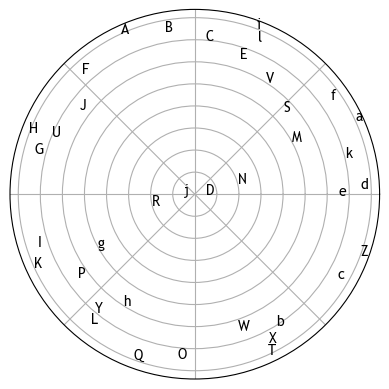

In [65]:
# Compute areas and colors
influence = abgrid_wide_i.loc[:, ["lettera_stu_i", "ic_raw_stu_i"]]
influence["ic_raw_stu_i"] = influence["ic_raw_stu_i"].rsub(influence["ic_raw_stu_i"].max() +1)
influence["theta"] = influence["ic_raw_stu_i"].div(2 * np.pi)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.grid(True)
ax.set_xticklabels([]);
ax.set_yticklabels([]);

for idx, (label, data) in enumerate(influence.groupby(by="ic_raw_stu_i")):
    offset = idx * .25
    data = data.reset_index(drop=True)
    nodes = data["lettera_stu_i"].values
    r = data["ic_raw_stu_i"]
    slice = (2 * np.pi) / data["ic_raw_stu_i"].shape[0]
    theta = pd.Series(data["ic_raw_stu_i"].index.values).mul(slice).add(offset)
    ax.scatter(theta, r, alpha=0)
    for i, txt in enumerate(nodes):
        ax.annotate(txt, (theta[i], r[i]))

fig.savefig("./analysis/polar.png", bbox_inches='tight')